# **Autoencoder presentacion intermedia**

# Librerias necesarias


In [1]:
#Librerias visualizacion de datos
!pip install xlsxwriter
from os import path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from google.colab import drive
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
from torchvision import transforms
import numpy as np
import os
import sys
import time



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.1 MB/s eta 0:00:00


# Datos

In [2]:
# Función para cargar archivos .pkl
def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [3]:
#Montaje de Google Drive
drive.mount('/content/drive')

#Datos
path_stamp_dataset_21_new = '/content/drive/MyDrive/Proyecto Inteligencia/Datos ZTF/stamp_dataset_21_new.pkl'
#path_stamp_dataset_28 = '/content/drive/MyDrive/Proyecto Inteligencia/Datos ZTF/stamp_dataset_28.pkl'

Mounted at /content/drive


In [4]:
#Cargar datasets

datos_stamp_dataset_21_new = cargar_datos(path_stamp_dataset_21_new)
#datos_stamp_dataset_28 = cargar_datos(path_stamp_dataset_28)

# Carga de datos

In [5]:
def print_keys(data, indent=0):
    for key, value in data.items():
        print(' ' * indent + str(key))
        if isinstance(value, dict):
            print_keys(value, indent + 2)
        elif isinstance(value, (list, tuple)):
            print(' ' * (indent + 2) + f'List/Tuple of length {len(value)}')
        elif hasattr(value, 'shape'):
            print(' ' * (indent + 2) + f'Shape: {value.shape}')
        else:
            print(' ' * (indent + 2) + str(type(value)))

print_keys(datos_stamp_dataset_21_new)

class StampDataset(Dataset):
    def __init__(self, data, split):
        self.images = data[split]['images']
        self.features = data[split]['features']
        self.label = data[split]['class']
        self.split = split

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.images[idx], self.features[idx], self.label[idx]

train_dataset = StampDataset(datos_stamp_dataset_21_new, 'Train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = StampDataset(datos_stamp_dataset_21_new, 'Validation')
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

Train
  images
    Shape: (72710, 21, 21, 3)
  features
    Shape: (72710, 26)
  oid
    Shape: (50594,)
  class
    Shape: (72710,)
Test
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)
Validation
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)


# Autoencoder


In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1),  # 21x21 -> 18x18
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 18x18 -> 18x18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 18x18 -> 9x9
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 9x9 -> 4x4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 4x4 -> 4x4
            nn.ReLU(),
            nn.Flatten(),  # 4x4x64 -> 1024
            nn.Linear(1024, 64),  # 1024 -> 64
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 1024),  # 64 -> 1024
            Reshape(-1, 64, 4, 4),  # Reshape to 64 channels, 4x4
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 9x9
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 18x18 -> 18x18
            nn.ReLU(),
            nn.Upsample(size=(21, 21), mode='bilinear', align_corners=True),  # Upsample from 18x18 -> 21x21
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # 21x21x16 -> 21x21x3
            nn.Sigmoid()  # Final output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Entrenamiento



In [7]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [8]:
# Crear el modelo
model = ConvAutoencoder()

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir la función de pérdida (RMSE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Entrenamiento
num_epochs = 15
outputs = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for img, _, _ in train_dataloader:
        img = img.to(device)
        img = img.float().permute(0, 3, 1, 2)

        # Paso hacia adelante: calcular las predicciones
        recon = model(img)

        # Calcular la pérdida (MSE y luego raíz cuadrada para obtener RMSE)
        mse_loss = criterion(recon, img)
        rmse_loss = torch.sqrt(mse_loss)

        # Backpropagación y optimización
        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()

        epoch_loss += rmse_loss.item()

    # Imprimir la pérdida promedio de la época
    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Guardar las imágenes originales y reconstruidas para visualizar
    outputs.append((epoch, img, recon))


Epoch [1/15], Loss: 0.0796
Epoch [2/15], Loss: 0.0572
Epoch [3/15], Loss: 0.0536
Epoch [4/15], Loss: 0.0514
Epoch [5/15], Loss: 0.0501
Epoch [6/15], Loss: 0.0492
Epoch [7/15], Loss: 0.0487
Epoch [8/15], Loss: 0.0483
Epoch [9/15], Loss: 0.0477
Epoch [10/15], Loss: 0.0474
Epoch [11/15], Loss: 0.0472
Epoch [12/15], Loss: 0.0470
Epoch [13/15], Loss: 0.0465
Epoch [14/15], Loss: 0.0464
Epoch [15/15], Loss: 0.0460


# Muestra de reconstrucción

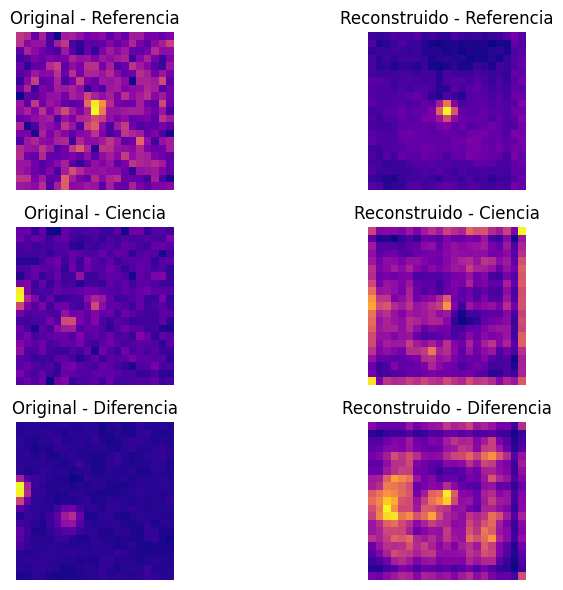

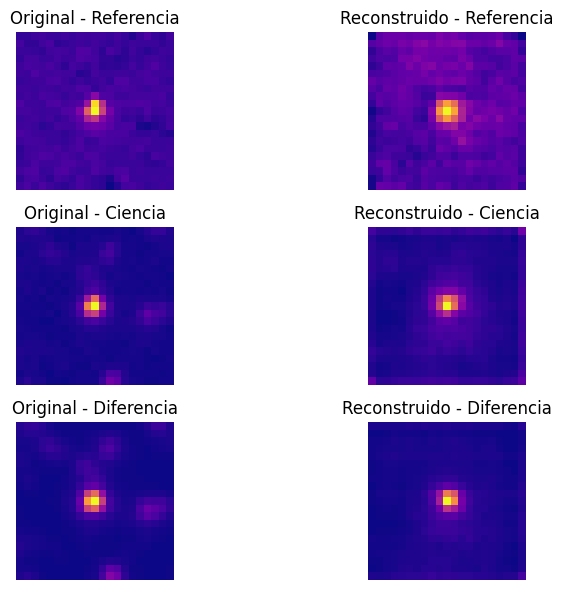

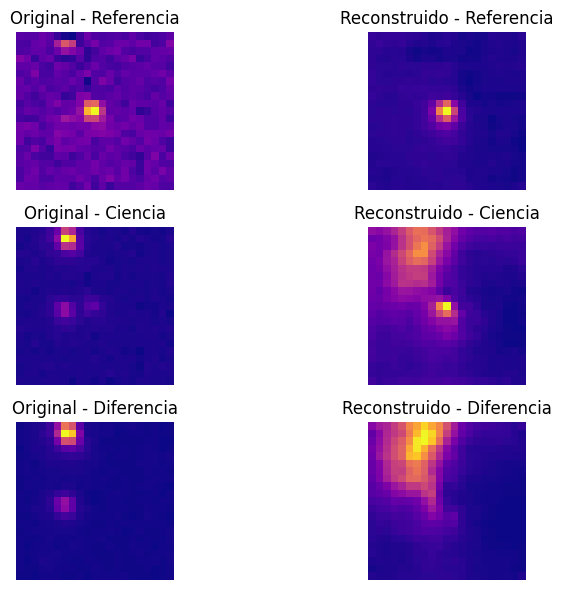

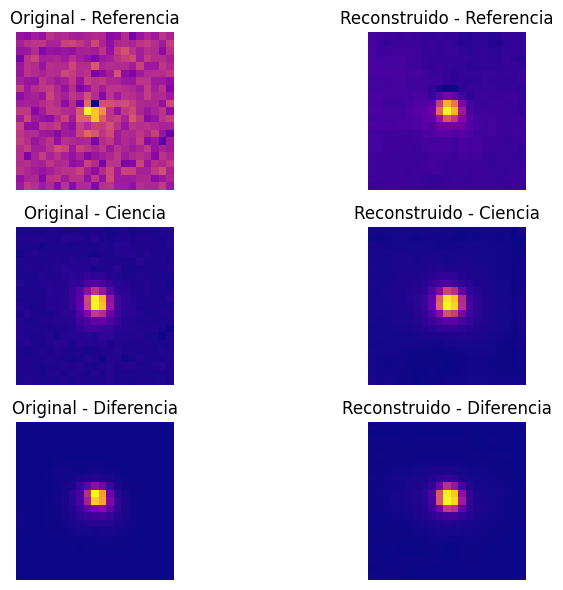

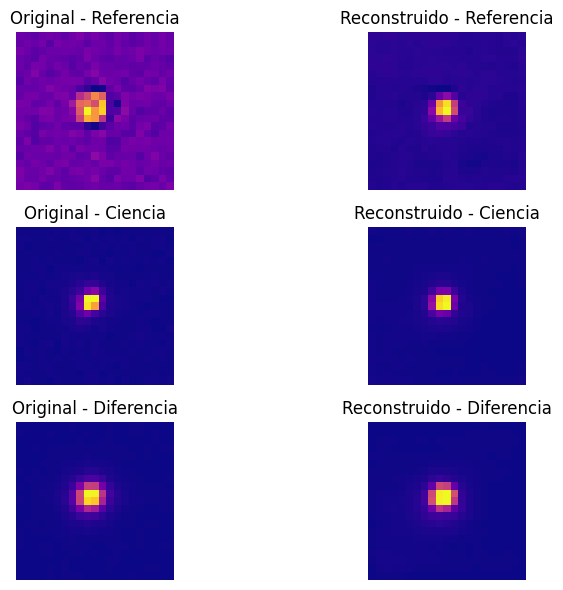

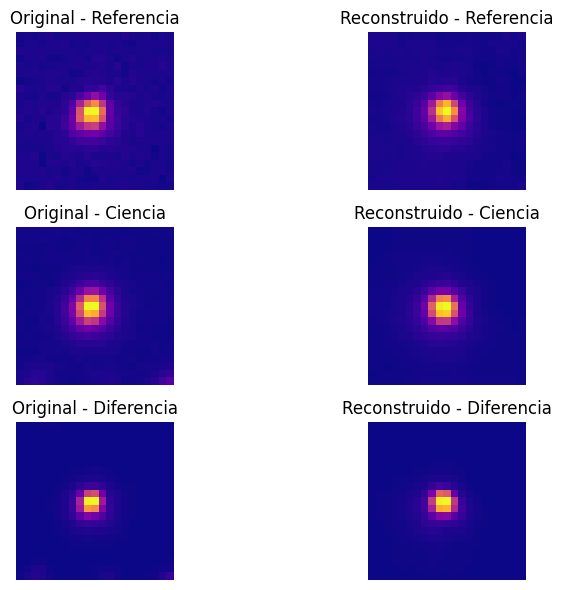

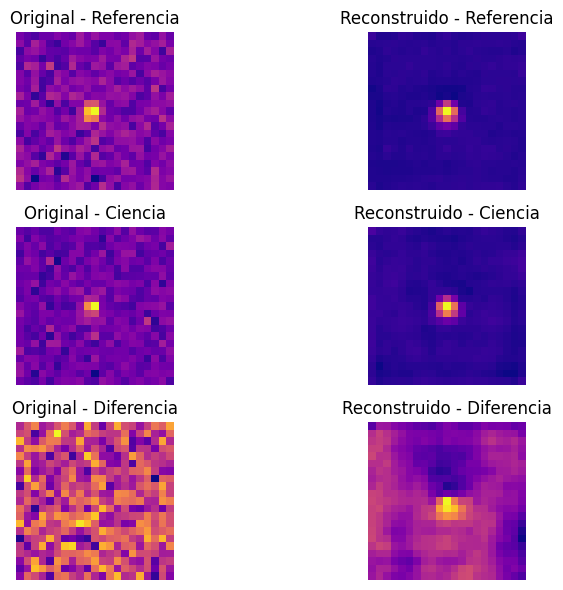

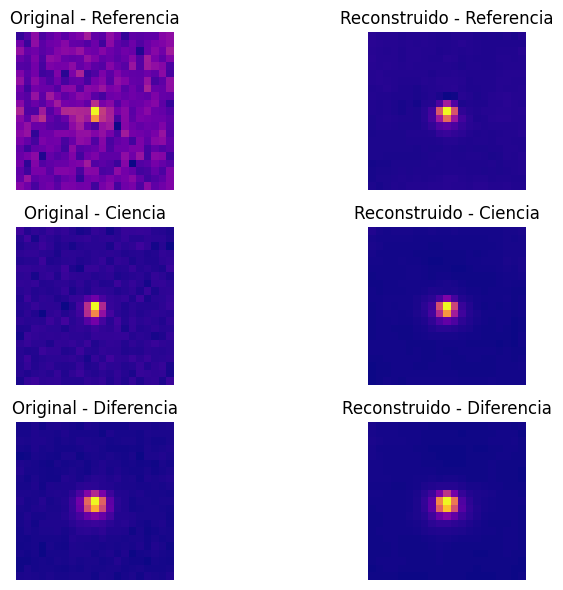

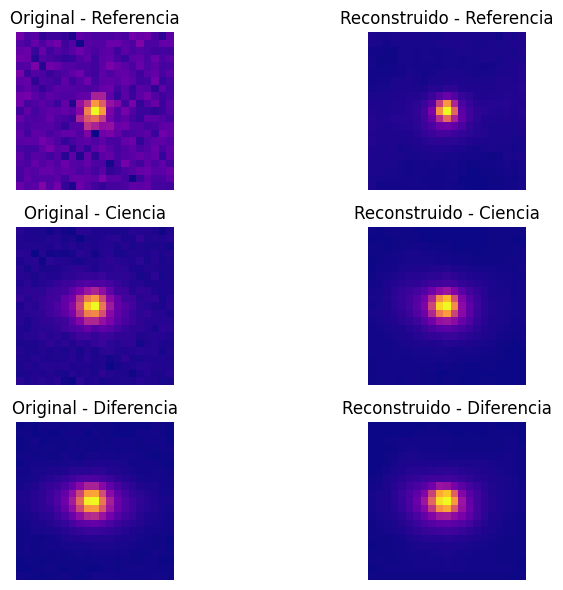

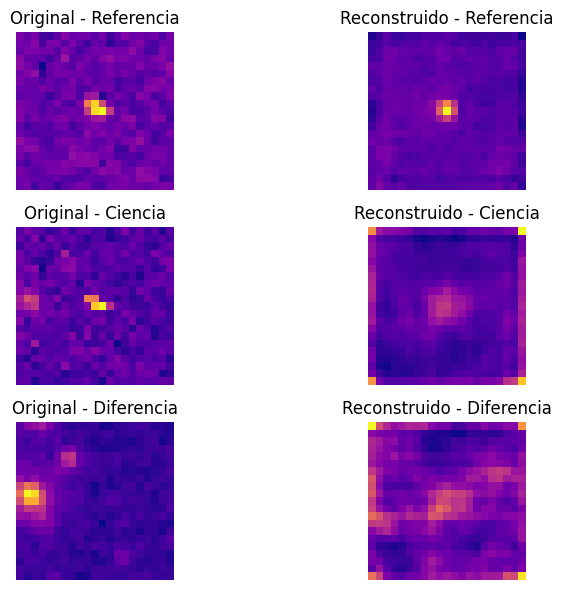

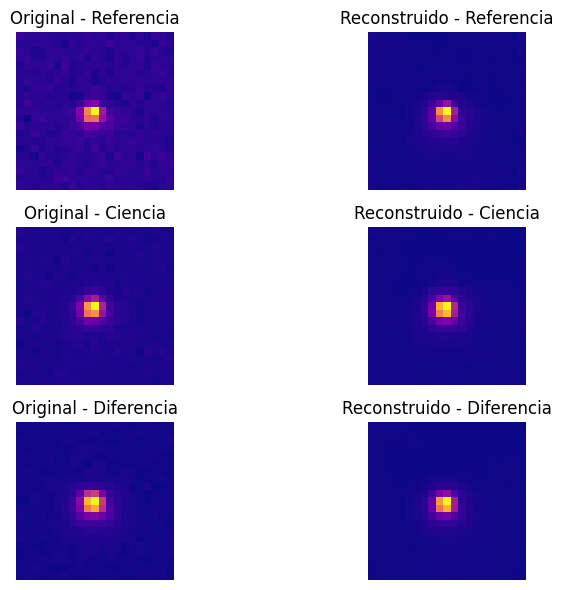

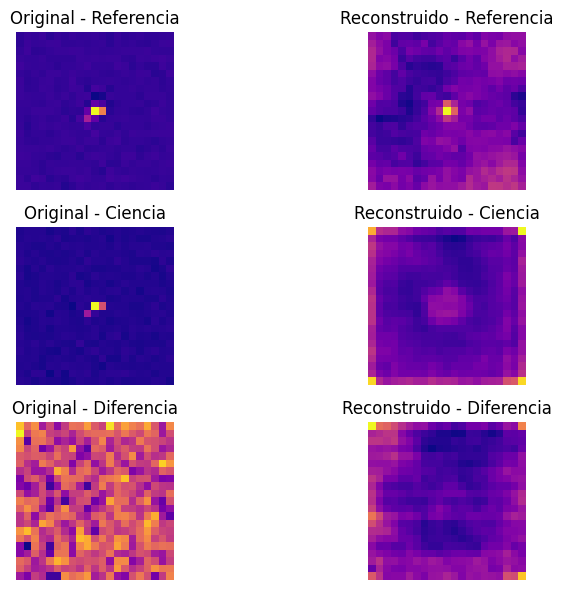

In [19]:
for k in range(12,):
    plt.figure(figsize=(9, 6))  # Ajustar el tamaño de la figura

    imgs = outputs[k][1].cpu().detach().numpy()  # Imágenes originales
    recon = outputs[k][2].cpu().detach().numpy()  # Imágenes reconstruidas

    # Mostrar la primera imagen original (con sus tres canales)
    for j in range(3):  # Tres canales: Referencia, Ciencia, Diferencia
        plt.subplot(3, 2, 2 * j + 1)
        plt.imshow(imgs[0][j], cmap='plasma')  # Canal j de la imagen 0
        plt.title(f'Original - {["Referencia", "Ciencia", "Diferencia"][j]}')
        plt.axis('off')

    # Mostrar la primera imagen reconstruida (con sus tres canales)
    for j in range(3):  # Tres canales: Referencia, Ciencia, Diferencia
        plt.subplot(3, 2, 2 * j + 2)
        plt.imshow(recon[0][j], cmap='plasma')  # Canal j de la imagen 0
        plt.title(f'Reconstruido - {["Referencia", "Ciencia", "Diferencia"][j]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()